In [1]:
#!pip3 install hnswlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import hnswlib
import pickle
import random

import numpy as np
from sklearn.linear_model import LinearRegression

random.seed(20230802)

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense


In [3]:
k=10
treatP = 0.5

In [4]:
n_videos = 29446
n_users = 933808

## Randomly generate embedding vectors for users and videos 

# Set the length and size of the embedding vectors
embedding_length = 16
embedding_size = n_videos
# Generate the list of embedding vectors with norm 1
embedding_list = []
for _ in range(embedding_size):
    embedding = np.random.randn(embedding_length).astype(float)
    embedding /= np.linalg.norm(embedding)
    embedding_list.append(",".join([str(elm) for elm in embedding]))
finder_emb_pd = pd.DataFrame({"finderuin": np.arange(n_videos), "embedding":embedding_list})


# Set the length and size of the embedding vectors
embedding_length = 16
embedding_size = n_users
# Generate the list of embedding vectors with norm 1
embedding_list = []
for _ in range(embedding_size):
    embedding = np.random.randn(embedding_length).astype(float)
    embedding /= np.linalg.norm(embedding)
    embedding_list.append(",".join([str(elm) for elm in embedding]))
uin_emb_pd = pd.DataFrame({"uin": np.arange(n_users), "embedding":embedding_list})


In [5]:
## Some Helper Functions 
def find_cosine(A_vec, B_vec):
    A = np.array([float(i) for i in A_vec])
    B = np.array([float(i) for i in B_vec])
    return float(np.dot(A,B)/(np.linalg.norm(A,2)*np.linalg.norm(B,2)))

def convert_string_to_vector(s):
    res = s.split(",")
    return np.array(res).astype(float)

def find_cosine_string(s1, s2):
    return find_cosine(convert_string_to_vector(s1), convert_string_to_vector(s2))

def mySoftMax(arr):
    num = np.exp(arr)
    denom = np.sum(num)
    return num/denom


def naive_est(res):
    treat_res = [elm[0] for elm in res[0]]
    control_res = [elm[1] for elm in res[0]]
    return np.mean(treat_res) - np.mean(control_res)


def dim_est(obs_T, obs_C):
    n1,n0 = len(obs_T), len(obs_C)
    return np.mean(obs_T) -np.mean(obs_C), np.sqrt(np.var(obs_T)/n1 + np.var(obs_C) / n0)


def point_est(all_treat_array, all_control_array):
    mus_T, mus_C  = all_treat_array[:, 11:21], all_control_array[:,11:21]
    p_T, p_C  = all_treat_array[:, 21:], all_control_array[:,21:]
    return np.mean(np.sum((mus_T * (p_T - p_C)), axis = 1 ))

In [6]:
   
tau = 15 
class Quota_New:
    def __init__(self, quota_id, finderuin, feature,current_time, duration, good_or_not, quota,treat, quota_level="", tag_class1=""):
        ## 每一个quota都有一个id，对应的创建者的finderuin，feature（128维的emb feature，string type，用逗号隔开； current_time是创建时间，duration是最多持续时间）
        ## good_or_not: 是否为好的quota indicator；quota-总的额度 
        self.quota = quota
        self.tag_class1 = tag_class1
        self.quota_id = quota_id
        self.findeurin = finderuin
        self.chaotou = 0
        self.feature = feature
        self.create_ts = current_time
        self.end_ts = self.create_ts + duration 
        self.good = good_or_not
        self.treat = treat
        
        
    def consume(self, amount):
        self.quota -= amount 
        if self.quota <0:
            self.chaotou += abs(self.quota)
            return True
        else:
            return False

        
tau = 15
class User:
    def __init__(self, uin, feature, treatStatus):
        self.uin = uin 
        self.feature = feature 
        # Store the information 
        self.hist = []
        self.total_budget = np.random.choice([50,100, 200,300, 400,500], p=[0.4,0.2,0.1,0.1,0.1, 0.1])
        self.treat = treatStatus
    def watch(self, quota_recommended):
        matching_score = find_cosine_string(self.feature, quota_recommended.feature)
        bid_est = 43 + 11 * matching_score 
        bid_est += quota_recommended.good * tau
        quota_recommended.consume(bid_est)
        self.total_budget -= bid_est 
        return bid_est
        
    
        
    

         
    
    
            
    

         
    
    
            

In [235]:
class Environment_Smart_Recommendation_tiquan:
    def __init__(self, uPool,qPool, initialization_feature_matrix,consideration_set_size = 10, feature_dim =16):
        
        self.userPool =uPool
        self.quotaPool = qPool
        self.consideration_set_size = consideration_set_size

                        
        self.p_all = hnswlib.Index(space = 'cosine', dim = feature_dim)
        self.p_all.init_index(max_elements = 4 * len(qPool), ef_construction = 200, M = 16)
        
        #self.p_all.set_ef(50)
        #self.p_good.set_ef(50)

        
        
        qIDs = []
        goodQuotaIDs = []
        treatQuotaIDs = []
        self.treatment_vector = []
 
        for i in range(len(qPool)):
            ithQuota = qPool[i]
            feature_vector = convert_string_to_vector(ithQuota.feature)
            qID = int(ithQuota.quota_id)
            self.quotaPool[qID]= ithQuota
            qIDs += [qID]
            self.p_all.add_items(feature_vector, qID)
            if ithQuota.good:
                goodQuotaIDs += [qID]
            if ithQuota.treat == True:
                treatQuotaIDs += [qID]
                self.treatment_vector += [1]
            else:
                self.treatment_vector += [0]
        self.treatment_vector = np.array(self.treatment_vector)
        self.goodQuotaIDs = goodQuotaIDs
        self.treatQuotaIDs = treatQuotaIDs

        
    def recommend(self, u):
        ## Return a quota index in the system that the user will watch and we can observe the result 
        u_feature_vector = convert_string_to_vector(u.feature)
        query_result = self.p_all.knn_query(u_feature_vector,k=self.consideration_set_size)
        
        candidates_, similarity_scores_ = np.array(query_result[0][0]), np.array(query_result[1][0])
        ## Heterogeneity: adding a constant to all the good sellers 
        good_indicator =  np.array([ind_i in self.goodQuotaIDs for ind_i in candidates_])
        treat_indicator = np.array([ind_i in self.treatQuotaIDs for ind_i in candidates_])
        
        added_similarity = 0.5 * treat_indicator * good_indicator * similarity_scores_
        
        probs = mySoftMax(similarity_scores_ + added_similarity)
        ## Exposure Indicators 
        expose_nums = np.random.choice([1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5], 1)[0]
        exposed_elements = probs.argsort()[-expose_nums:][::-1]
        expose_vector = np.array([int(i in exposed_elements) for i in range(len(probs))])
        
        
        ## Consideration set feature 
        consideration_set_feature = np.array([self.quotaPool[ind_i].feature for ind_i in candidates_])
        
        return candidates_, probs,similarity_scores_, expose_vector, treat_indicator, good_indicator, u_feature_vector, consideration_set_feature  
        
        
    def recommend_in_parallel(self, u):
        ## Return a quota index in the system that the user will watch and we can observe the result 
        u_feature_vector = convert_string_to_vector(u.feature)
        query_result = self.p_all.knn_query(u_feature_vector,k=self.consideration_set_size)
        
        candidates_, similarity_scores_ = np.array(query_result[0][0]), np.array(query_result[1][0])
        ## Heterogeneity: adding a constant to all the good sellers 
        good_indicator =  np.array([ind_i in self.goodQuotaIDs for ind_i in candidates_])
        treat_indicator = np.array([ind_i in self.treatQuotaIDs for ind_i in candidates_])
        
        added_similarity = 0.05 * treat_indicator * good_indicator
        ## added similarity in all treated world 
        added_similarity_T = 0.5 * good_indicator 
        ## added similarity in all control world 
        added_similarity_C = 0
        probs = mySoftMax(similarity_scores_ + added_similarity)
        probs_T = mySoftMax(similarity_scores_ + added_similarity_T)
        probs_C = mySoftMax(similarity_scores_ + added_similarity_C)
        ## Exposure Indicators 
        expose_nums = np.random.choice([1,1,1,1,1,1,1,1,1,1,1,1], 1)[0]
        exposed_elements = probs.argsort()[-expose_nums:][::-1]
        expose_vector = np.array([int(i in exposed_elements) for i in range(len(probs))])
        
        ## Exposure Indicators in All Treated World 
        exposed_elements_T = probs_T.argsort()[-expose_nums:][::-1]
        expose_vector_T = np.array([int(i in exposed_elements_T) for i in range(len(probs_T))])
        ## Exposure Indicator in All Control World 
        exposed_elements_C = probs_C.argsort()[-expose_nums:][::-1]
        expose_vector_C = np.array([int(i in exposed_elements_C) for i in range(len(probs_C))])

        ## Consideration set feature 
        consideration_set_feature = np.array([self.quotaPool[ind_i].feature for ind_i in candidates_])
        
        return candidates_, probs,similarity_scores_, expose_vector, treat_indicator, good_indicator, u_feature_vector, consideration_set_feature, expose_vector_T, expose_vector_C, probs_T, probs_C
    
    def run_experiment(self, T, user_arrival_probability=0.999,verbose = False):
        traj = []
        ended_quotas = []
        quota_arrival_probability = 1 - user_arrival_probability
        index_tracker = len(self.quotaPool) + 1
        samples = []
        
        for t in range(T):
                ## Recommendation 
            user_coming_index = np.random.choice(np.arange(len(self.userPool)))
            user = self.userPool[user_coming_index]
            candidates_, probs,similarity_scores, expose_vector, treat_indicator, good_indicator, u_feat, vu_feats = self.recommend(user)
            
            rewards = []
            for i in range(len(expose_vector)):
                if expose_vector[i] == 0:
                    rewards += [0]
                else:
                    recommended_quota = self.quotaPool[candidates_[i]]
                    reward = user.watch(recommended_quota)
                    rewards += [reward]
            samples += [[user_coming_index,rewards, candidates_, probs,similarity_scores, expose_vector, treat_indicator, good_indicator, u_feat, vu_feats]]
                        #0                   1            2        3        4                   5               6            7               8         9
        return samples
    
    def run_experiment_parallel_world(self, T,user_arrival_probability=0.999,verbose = False):
        traj = []
        ended_quotas = []
        quota_arrival_probability = 1 - user_arrival_probability
        index_tracker = len(self.quotaPool) + 1
        samples = []
        samples_T,samples_C = [],[]
        rewards_seller, rewards_seller_T, rewards_seller_C = np.zeros(len(self.quotaPool)), np.zeros(len(self.quotaPool)), np.zeros(len(self.quotaPool))
        for t in range(T):
            ## Recommendation 
            ## Step 1: randomly pick a user from user pool 
            user_coming_index = np.random.choice(np.arange(len(self.userPool)))
            user = self.userPool[user_coming_index]
            ## Step 2: recommend some videos to the user; since we know the ground truth - the recommend_in_parallel would also return the 
            ## quantities as if all the sellers were treated or controlled  
            candidates_, probs,similarity_scores, expose_vector, treat_indicator, good_indicator, u_feat, vu_feats, e_T, e_C, p_T, p_C = self.recommend_in_parallel(user)
            
            ## Step 3: Generate outcomes(rewards), and record the status 
            rewards = []
            rewards_T = []
            rewards_C = []
            for i in range(len(expose_vector)):
                ## World I: Real world, W~Bernoulli(0.5)
                if expose_vector[i] == 0:
                    rewards += [0]
                else:
                    recommended_quota = self.quotaPool[candidates_[i]]
                    reward = user.watch(recommended_quota)
                    rewards += [reward]
                    rewards_seller[candidates_[i]] += reward
                
                ## World II: All treated world , W~Bernoulli(1)
                if e_T[i] == 0:
                    rewards_T += [0]
                else:
                    recommended_quota = self.quotaPool[candidates_[i]]
                    reward = user.watch(recommended_quota)
                    rewards_T += [reward]
                    rewards_seller_T[candidates_[i]] += reward
                
                ## World III: All control world , W~Bernoulli(0)
                if e_C[i] == 0:
                    rewards_C += [0]
                else:
                    recommended_quota = self.quotaPool[candidates_[i]]
                    reward = user.watch(recommended_quota)
                    rewards_C += [reward]
                    rewards_seller_C[candidates_[i]] += reward
                    
            samples += [[user_coming_index,rewards, candidates_, probs,similarity_scores, expose_vector, treat_indicator, good_indicator, u_feat, vu_feats]]
                        #0                   1            2        3        4                   5               6            7               8         9
            samples_T += [[user_coming_index,rewards_T, candidates_, p_T,similarity_scores, e_T, treat_indicator, good_indicator, u_feat, vu_feats]]
            samples_C += [[user_coming_index,rewards_C, candidates_, p_C,similarity_scores, e_C, treat_indicator, good_indicator, u_feat, vu_feats]]
        return samples, samples_T, samples_C, rewards_seller, rewards_seller_T, rewards_seller_C 


In [236]:
def naive_dim(res):
    rewards_matrix = np.array([elm[1] for elm in res])
    
    expose_matrix = np.array([elm[5] for elm in res])

    treat_matrix = np.array([elm[6] for elm in res])
    
    treat_samples = rewards_matrix[(expose_matrix * treat_matrix)==1] 
    control_samples = rewards_matrix[(expose_matrix * (1-treat_matrix))==1] 
    
    n1, n0 = len(treat_samples), len(control_samples)
    return np.mean(treat_samples) - np.mean(control_samples), np.sqrt(np.var(treat_samples) / n1 + np.var(control_samples) / n0)


In [237]:
def group_mean(res):
    rewards_matrix = np.array([elm[1] for elm in res])
    
    expose_matrix = np.array([elm[5] for elm in res])

    samples = rewards_matrix[expose_matrix==1]
    return np.mean(samples), np.var(samples) / len(samples)

In [238]:
## Generate elements in the two-sided market 
quota_size = 1000
finder_size = 700
user_size=10000
user_df_inds = np.arange(len(uin_emb_pd))
sample_ind = np.random.choice(user_df_inds, size=user_size, replace=False)
goodBads=[True, False, False, False]
user_pool = []
for i in range(user_size):
    user_ind = sample_ind[i]
    user_pool += [User(uin_emb_pd.iloc[user_ind,1], uin_emb_pd.iloc[user_ind,1], np.random.choice([False, False]))]
#user_size = quota_size * 300
finder_sample_ind = np.random.choice(np.arange(len(finder_emb_pd)),size = finder_size, replace = False)
quota_pool = []
quota_pool_treat = []
quota_pool_control = [] 
for i in range(quota_size):
    finder_ind = np.random.choice(finder_sample_ind)
    g = np.random.choice(goodBads)
    q_new = Quota_New(str(i), finder_emb_pd.iloc[finder_ind,1], finder_emb_pd.iloc[finder_ind,1], 0, 100000, g,  9999999999,np.random.choice([True, False]))
    q_new_treat = Quota_New(str(i), finder_emb_pd.iloc[finder_ind,1], finder_emb_pd.iloc[finder_ind,1], 0, 100000, g,  9999999999,np.random.choice([True, True]))
    q_new_control = Quota_New(str(i), finder_emb_pd.iloc[finder_ind,1], finder_emb_pd.iloc[finder_ind,1], 0, 100000,g,  9999999999,np.random.choice([False, False]))
    quota_pool += [q_new]
    quota_pool_treat += [q_new_treat]
    quota_pool_control += [q_new_control]


## Step 1: Create an environment and run some recommendations

In [340]:
## Create expt environment
expt_717 = Environment_Smart_Recommendation_tiquan(user_pool, quota_pool, np.array([convert_string_to_vector(elm) for elm in finder_emb_pd.iloc[finder_sample_ind,1]]))
res_717_mixed, res_717_T, res_717_C, rew_seller, rew_seller_T, rew_seller_C =  expt_717.run_experiment_parallel_world(10000)

- Process the data for further analysis 

In [342]:
## Construct outcomes to the model 
is_selected_indicator = tf.convert_to_tensor(np.array([elm[5] for elm in res_717_mixed]), dtype = float)
reward_array =np.array([elm[5].T@elm[1] for elm in res_717_mixed]).reshape(len(res_717_mixed),1)

outcome_tensor = tf.convert_to_tensor(reward_array, dtype = float)
# Expsoure indicator and outcomt; can be seen as the label in model fitting 

exposure_indicator_outcome = tf.concat([is_selected_indicator, outcome_tensor,is_selected_indicator], axis = 1)

treatTable = np.array([elm[6] for elm in res_717_mixed])

In [343]:

## Get treatment indicator matrix
w_dict = {}
groupNames = [0,1]
for v in groupNames:
    w_dict[v] = tf.convert_to_tensor(treatTable == v, dtype = float)

w_all_treat = tf.convert_to_tensor(np.array([[1] * k for _ in range(treatTable.shape[0])],dtype='float32'))
w_all_control = tf.convert_to_tensor(np.array([[0] * k for _ in range(treatTable.shape[0])],dtype='float32'))


In [344]:
exposed_score = np.array([elm[4].T@elm[5] for elm in res_717_mixed])

In [345]:
exposed_good = np.array([elm[7].T@elm[5] for elm in res_717_mixed])

In [346]:
exposed_rewards =  np.array([np.array(elm[1]).T@elm[5] for elm in res_717_mixed])

In [348]:
import numpy as np
import statsmodels.api as sm
X = np.array([exposed_score, exposed_good]).T
X = sm.add_constant(X)
model = sm.OLS(exposed_rewards, X)
results = model.fit()

In [349]:
results.params

array([ 53.99999936, -10.9999994 ,  14.99999995])

In [350]:
predicted_outcomes_input =  np.array([results.predict(sm.add_constant(np.array([elm[4], elm[7]]).T)) for elm in res_717_mixed])

In [351]:
predicted_outcomes_input_tensor = tf.convert_to_tensor(predicted_outcomes_input, dtype = float)

In [352]:
## Construct inputs to the model 
ith_treat= 1
inputs_scores = tf.convert_to_tensor( np.array([elm[4] for elm in res_717_mixed]),dtype = float)
inputs_good = tf.convert_to_tensor( np.array([elm[7] for elm in res_717_mixed]),dtype = float)
inputs_3d = tf.stack([inputs_scores]+[inputs_good] + [w_dict[v] for v in groupNames  if v > 0] + [predicted_outcomes_input_tensor] , axis = 2)

inputs_all_treat_3d = tf.stack([inputs_scores]+[inputs_good] + [w_all_treat if v== ith_treat else w_all_control for v in groupNames if v>0] +[predicted_outcomes_input_tensor], axis = 2)
inputs_all_control_3d = tf.stack([inputs_scores]+[inputs_good] + [w_all_control for v in groupNames if v>0] +[predicted_outcomes_input_tensor], axis = 2)
inputs_all_treat_3d_test = inputs_all_treat_3d[int(split_index):,:] 
inputs_all_control_3d_test = inputs_all_control_3d[int(split_index):,:]

In [353]:
# inputs_3d = tf.stack([inputs_scores]+[inputs_good] + [w_dict[v] for v in groupNames  if v > 0]  , axis = 2)

# inputs_all_treat_3d = tf.stack([inputs_scores]+[inputs_good] + [w_all_treat if v== ith_treat else w_all_control for v in groupNames if v>0] , axis = 2)
# inputs_all_control_3d = tf.stack([inputs_scores]+[inputs_good] + [w_all_control for v in groupNames if v>0] , axis = 2)


In [354]:
## Modifying the tensor for 3d input 
class MyModel_multiple_simple_layers_0911(Model):
    def __init__(self, k, num_treats,predictY=False):
        super(MyModel_multiple_simple_layers_0911, self).__init__()
        self.k = k
        self.num_treats = num_treats
        self.groupNames = ['A'] + ['B' + str(i+1) for i in range(self.num_treats)]
        
        self.baseline_logit = Dense(1, activation = "relu")
        self.logit_dense_layer = {} 
        for g in self.groupNames:
            self.logit_dense_layer[g] = Dense(1, activation = "relu")
        self.common_hidden = Dense(5, activation = "relu")
        self.softmax = Dense(k, activation='softmax')
        
        self.predictY = predictY
        self.d5 = Dense(1, activation = "relu")
        self.doutcome = Dense(1)
        
        self.d_onehot = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.argmax(x, axis=-1), k))
        
    
    def call(self, inputs):

        split_structure =  [2] + [1] * self.num_treats + [1]
        splitted_elements = tf.split(inputs, split_structure, axis=2)
        x1 = splitted_elements[0]
        ypredicts = splitted_elements[-1]
        
        print(ypredicts.shape, " shape of the prediction")
        
        
        ## Step 1: Reshape the input 
        
        reshape_x1 = tf.reshape(x1, (-1, x1.shape[-1]))
        
        ## Step 2: a common hidden layer
        x1_common_hidden = self.common_hidden(reshape_x1)
        
        #x1_common_hidden_3d = tf.reshape(x1_common_hidden, [x1.shape[0],self.k, x1_common_hidden.shape[1]])
        x1_common_hidden_3d = tf.reshape(x1_common_hidden,[-1, k, 5])
        
        ## Baseline logit
        x1_final = self.baseline_logit(x1_common_hidden_3d)
       # Create a mask of ones with the same shape as x
          # Create a mask of ones with the same shape as x
        mask = tf.ones_like(x1_final)

        # Get the dynamic shape of x
        x_dynamic_shape = tf.shape(x1_final)

        # Create indices for the first column in the second dimension
        indices = tf.stack([tf.range(x_dynamic_shape[0]), tf.zeros(x_dynamic_shape[0], dtype=tf.int32), tf.zeros(x_dynamic_shape[0], dtype=tf.int32)], axis=1)

        # Create updates (all zeros)
        updates = tf.zeros(x_dynamic_shape[0])

        # Use tf.tensor_scatter_nd_update to apply the updates
        mask = tf.tensor_scatter_nd_update(mask, indices, updates)

        # Apply the mask to x
        x1_final = x1_final * mask

        ## Step 3: logit model
        for i in range(self.num_treats):
            print("Here")
            w_g = splitted_elements[i + 1]
            xg_hidden = self.logit_dense_layer['B'+str(i+1)](x1_common_hidden_3d)
            x1_final = tf.add(tf.multiply(w_g, xg_hidden), x1_final)
            
        ## Step 4: Softmax
        reshaped_data = tf.squeeze(x1_final, axis=-1)
        softmax_p =  self.softmax(reshaped_data)



        y1 = self.d_onehot(softmax_p)
        
        if self.predictY:
            x5 = self.d5(x1)
            x5 = tf.squeeze(x5, axis=-1)
            pairwise_outcome = x5
            y2 = tf.reduce_sum(tf.multiply(softmax_p, x5), axis = 1 )
            y2 = tf.expand_dims(y2, axis=-1)
        else:
            
            ypredicts = splitted_elements[-1]
            print(ypredicts.shape, " predict shape")
            ypredicts = tf.squeeze(ypredicts, axis=-1)
            print("ypredicts shape", ypredicts.shape)
            pairwise_outcome = ypredicts
            y2 = tf.reduce_sum(tf.multiply(softmax_p, ypredicts), axis = 1 )
            y2 = tf.expand_dims(y2, axis=-1)
            
        # ## One hot vector  
        # y1 = softmax_p
        # x5 = self.d5(ypredicts)
        # print("softmax shape", y1.shape)
        
        # ## Outcome 
    
        # y2 = self.doutcome(tf.multiply(y1, x5))
        


        res = tf.concat([softmax_p,y2,pairwise_outcome], axis=1)
        print(res.shape, " result shape")
        return res


In [355]:
# Define custom loss function
def custom_loss(y_true, y_pred):

    y1_true, y2_true,_ = tf.split(y_true, [k, 1,k], axis=1)
    y1_pred, y2_pred,_ = tf.split(y_pred, [k, 1,k], axis=1)


    loss1 = tf.keras.losses.BinaryCrossentropy()(y1_true, y1_pred)
    #loss2 = tf.keras.losses.MeanSquaredError()(y2_true, y2_pred)
    return loss1

## Step 2: Fit choice probability model 

In [356]:
# Compile the model
## Start training the model and inference


# Get the total number of rows in the tensor
num_rows =inputs_3d.shape[0]

# Calculate the split index based on the desired percentages
split_index = tf.constant(int(num_rows * 0.2))

# Split the tensor into training and test sets
inputs_3d_train_set, inputs_3d_test_set = tf.split(inputs_3d, [split_index, num_rows - split_index], axis=0)
exposure_indicator_outcome_train_set, exposure_indicator_outcome_test_set =  tf.split(exposure_indicator_outcome, [split_index, num_rows - split_index], axis=0)


# myModelMultiple = MyModel_multiple_simple_layers_0911(k, 1, predictY= False)
# myModelMultiple.compile(loss=custom_loss,optimizer=tf.keras.optimizers.legacy.Adam())
# myModelMultiple.fit(inputs_3d_train_set, exposure_indicator_outcome_train_set,epochs=10,verbose=True)

In [357]:
# Compile the model
## Start training the model and inference


# Get the total number of rows in the tensor
num_rows =inputs_3d.shape[0]

# Calculate the split index based on the desired percentages
split_index = tf.constant(int(num_rows * 0.2))

# Split the tensor into training and test sets
inputs_3d_train_set, inputs_3d_test_set = tf.split(inputs_3d, [split_index, num_rows - split_index], axis=0)
exposure_indicator_outcome_train_set, exposure_indicator_outcome_test_set =  tf.split(exposure_indicator_outcome, [split_index, num_rows - split_index], axis=0)


myModelMultiple = MyModel_multiple_simple_layers_0911(k, 1, predictY= False)
myModelMultiple.compile(loss=custom_loss,optimizer=tf.keras.optimizers.legacy.Adam())
myModelMultiple.fit(inputs_3d_train_set, exposure_indicator_outcome_train_set,epochs=10,verbose=True)

Epoch 1/10
(None, 10, 1)  shape of the prediction
Here
(None, 10, 1)  predict shape
ypredicts shape (None, 10)
(None, 21)  result shape
(None, 10, 1)  shape of the prediction
Here
(None, 10, 1)  predict shape
ypredicts shape (None, 10)
(None, 21)  result shape
63/63 [==============================] - 0s 685us/step - loss: 0.3181
Epoch 2/10
63/63 [==============================] - 0s 527us/step - loss: 0.2929
Epoch 3/10
63/63 [==============================] - 0s 909us/step - loss: 0.2556
Epoch 4/10
63/63 [==============================] - 0s 467us/step - loss: 0.2374
Epoch 5/10
63/63 [==============================] - 0s 453us/step - loss: 0.2317
Epoch 6/10
63/63 [==============================] - 0s 448us/step - loss: 0.2276
Epoch 7/10
63/63 [==============================] - 0s 452us/step - loss: 0.2238
Epoch 8/10
63/63 [==============================] - 0s 440us/step - loss: 0.2196
Epoch 9/10
63/63 [==============================] - 0s 480us/step - loss: 0.2145
Epoch 10/10
63/63 [==

In [360]:
predicted_outcomes_input_tensor_test = predicted_outcomes_input_tensor[int(split_index):,:]

In [361]:
## Monte Carlo estimation of expected exposure probability
##  (over the randomness of treatment assignment among the videos in the consideration set)
M = 100
exposure_indicator_array_test = np.array([elm[5] for elm in res_717_mixed])[int(split_index):,:]
montecarlo_expected_probability_test = np.zeros(exposure_indicator_array[int(split_index):,:].shape)
for m in range(M):
    w_m = np.random.choice([0] + [i + 1 for i in range(len(groupNames)-1)], size = w_all_treat[int(split_index):,:].shape, replace=True)
    input_list = [inputs_scores_test,inputs_good_test] 
    for i in range(len(groupNames)-1):
        w_matrix = 1.0 * (w_m == i)
        w_m_tensor = tf.convert_to_tensor(w_matrix, dtype='float32')
        input_list = input_list + [w_m_tensor] + [predicted_outcomes_input_tensor_test]
    inputs_m = tf.stack(input_list, axis = 2)
    model_pred_m = np.array(myModelMultiple.predict(inputs_m))[:,:k]
    montecarlo_expected_probability_test = montecarlo_expected_probability_test + model_pred_m
    
montecarlo_expected_probability_test = montecarlo_expected_probability_test / M


(32, 10, 1)  shape of the prediction
Here
(32, 10, 1)  predict shape
ypredicts shape (32, 10)
(32, 21)  result shape
250/250 [==============================] - 0s 336us/step


In [362]:
all_treat_array, all_control_array =  myModelMultiple.predict(inputs_all_treat_3d_test),myModelMultiple.predict(inputs_all_control_3d_test)
mus_T, mus_C = all_treat_array[:, -k:],all_control_array[:,-k:]

  1/250 [..............................] - ETA: 2s

250/250 [==============================] - 0s 340us/step


In [363]:
p_T, p_C  = all_treat_array[:, :k], all_control_array[:,:k]


## Step 3: Run inference 

In [365]:
treatment_indicator_array = 1 * (treatTable == ith_treat)

In [366]:
pv1,pv0 = np.sum(exposure_indicator_array[int(split_index):,:] * p_T, axis = 1), np.sum(exposure_indicator_array[int(split_index):,:] * p_C, axis = 1)

In [367]:
pv_given_uvw = p_T * treatment_indicator_array[int(split_index):,:] + p_C * (1 - treatment_indicator_array[int(split_index):,:])


In [368]:
rewards_array = np.array([elm[1] for elm in res_717_mixed])[int(split_index):,:]

In [369]:
Ey1,Ey0 = np.sum(mus_T * p_T, axis = 1), np.sum(mus_C * p_C, axis = 1)

In [370]:
## Compute gradient of loss function (n by 3* K - 1)
dl1dtheta0 = pv_given_uvw - exposure_indicator_array[int(split_index):,:]
dl1dtheta0 = dl1dtheta0[:, 1:] 

dl1dtheta1 = treatment_indicator_array[int(split_index):,:] * (pv_given_uvw - exposure_indicator_array[int(split_index):,:])
dl2dmu = exposure_indicator_array[int(split_index):,:] * (mus_T -rewards_array)
gradient_vector_l = np.concatenate([dl1dtheta0,dl1dtheta1,dl2dmu], axis =1 )

In [371]:
## Compute gradient of H function (n by 3 * K - 1)
dHdtheta0 = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1)) - p_C * (mus_C - Ey0.reshape(mus_C.shape[0],1))
dHdtheta0 = dHdtheta0[:, 1:]
dHdthetal = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1))
dHdmu = p_T - p_C
gradient_vector_H = np.concatenate([dHdtheta0,dHdthetal,dHdmu], axis =1 )

In [372]:

## Hessian elements 
# k-1 by k-1 
d2l2dtheta0 = - np.array([np.outer(row_, row_) for row_ in montecarlo_expected_probability_test])
# k by k
d2l2dtheta1 = -treatP * np.array([np.outer(row_, row_) for row_ in montecarlo_expected_probability_test])

d2l2dtheta01 = -treatP * treatP * np.array([np.outer(row_, row_) for row_ in montecarlo_expected_probability_test])

d2l2dmu = np.zeros(d2l2dtheta1.shape)
## Change the diagonal element
for i in range(d2l2dmu.shape[0]):
    p_1minusp_i = (1 - montecarlo_expected_probability_test[i,:]) * (1 - montecarlo_expected_probability_test[i,:])
    treatment_i = treatment_indicator_array[i,:]
    exposure_i = exposure_indicator_array[i,:]
    np.fill_diagonal(d2l2dtheta0[i], p_1minusp_i)
    np.fill_diagonal(d2l2dtheta1[i], treatP* p_1minusp_i)
    np.fill_diagonal(d2l2dmu[i], montecarlo_expected_probability_test[i,:])
    np.fill_diagonal(d2l2dtheta01[i], treatP * p_1minusp_i)


In [373]:
d2l2dtheta0 = d2l2dtheta0[:,1:, 1:]
d2l2dtheta01_k_m_1_by_k = d2l2dtheta01[:, 1:,:]
d2l2dtheta10_k_by_k_m_1 = d2l2dtheta01[:, :,1:]

In [374]:
## Concate
Hessian_first_row = np.concatenate((d2l2dtheta0, d2l2dtheta01_k_m_1_by_k, np.zeros(d2l2dtheta01_k_m_1_by_k.shape)), axis =2)
Hessian_second_row = np.concatenate((d2l2dtheta10_k_by_k_m_1, d2l2dtheta1, np.zeros(d2l2dtheta1.shape)), axis =2)
Hessian_third_row = np.concatenate((np.zeros(d2l2dtheta10_k_by_k_m_1.shape), np.zeros(d2l2dmu.shape), d2l2dmu), axis =2)

Hessian = np.concatenate((Hessian_first_row, Hessian_second_row, Hessian_third_row), axis = 1 )


In [375]:
count_finite = 0
score_funcs = np.zeros(len(Hessian))
for i in range(len(Hessian)):
    if np.isfinite(np.linalg.cond(Hessian[i])):
        score_funcs[i] = gradient_vector_H[i]@Hessian[i]@gradient_vector_l[i]
        count_finite += 1 

In [376]:
res_tempt = np.array(myModelMultiple.predict(inputs_all_treat_3d_test)) - np.array(myModelMultiple.predict(inputs_all_control_3d_test))

  1/250 [..............................] - ETA: 2s

250/250 [==============================] - 0s 395us/step


In [377]:
## 
H_funcs_new = np.sum(res_tempt[:, :k] * predicted_outcomes_input[int(split_index):,:], axis = 1 )

In [378]:
def naive_dim_estimate(vector_T, vector_C):
    return np.mean(vector_T, vector_C), np.var(vector_T)/len(vecotr_T) + np.var(vector_C) / len(vector_C)

In [379]:
def debias_estimator(Hfuncs, influence_funcs):
    return np.mean(Hfuncs - influence_funcs), np.var(influence_funcs) / len(influence_funcs)

## Experiment to Show the Performance of Estimator 

In [147]:
B = 100 
truth_list = []
for b in range(B):
    if b % 10 ==0:
        print(b)
    ## Create expt environment
    expt_717 = Environment_Smart_Recommendation_tiquan(user_pool, quota_pool, np.array([convert_string_to_vector(elm) for elm in finder_emb_pd.iloc[finder_sample_ind,1]]))
    res_717_mixed, res_717_T, res_717_C, rew_seller, rew_seller_T, rew_seller_C =  expt_717.run_experiment_parallel_world(10000)

    T_obs = [np.sum(elm[1]) for elm in res_717_T]
    C_obs = [np.sum(elm[1]) for elm in res_717_C]
    truth_list += [np.mean(T_obs) - np.mean(C_obs)]

0
10


KeyboardInterrupt: 

(array([1., 2., 0., 1., 5., 2., 3., 1., 1., 1.]),
 array([10.4195245 , 10.44381024, 10.46809598, 10.49238172, 10.51666746,
        10.54095321, 10.56523895, 10.58952469, 10.61381043, 10.63809617,
        10.66238191]),
 <BarContainer object of 10 artists>)

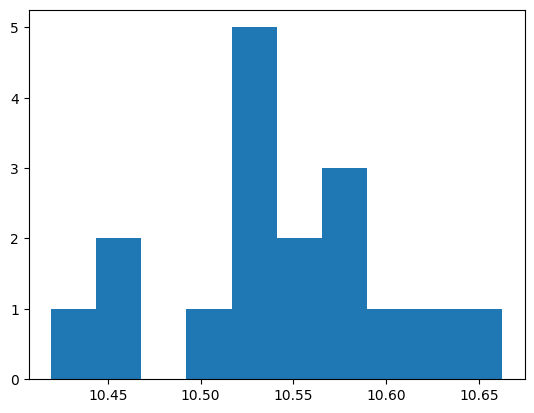

In [215]:
plt.hist(truth_list)